In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
import pandas as pa
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import unicodedata
import pylab
import sys
from __future__ import unicode_literals
pylab.rcParams['figure.figsize'] = (17.0, 11.0)
matplotlib.rcParams['savefig.dpi'] = 250

In [2]:
data = pa.read_csv('wybory-2015-obwody.csv', low_memory=False, encoding="utf8")

In [3]:
#popraw blad w csvce (sa 2 komitety o numerze 16)
colnames = list(data.columns)
colnames[-1] = colnames[-1].replace("6", "7")
data.columns = colnames

In [4]:
data.fillna(0, inplace=True)

In [ ]:
data.describe()

In [5]:
for i in xrange(len(colnames)):
    s = "{0} : {1}".format(i, colnames[i])
    print s

0 : Nr okr.
Sejm
1 : Nr okr.
Senat
2 : TERYT
3 : Gmina
4 : Nr obw.
5 : Adres
6 : Liczba wyborców
7 : Otrzymane karty
8 : Niewykorzystane karty
9 : Wydane karty
10 : Liczba wyborców głosujących przez pełnomocnika
11 : Liczba wyborców głosujących na podstawie zaświadczenia
12 : Pakiety wyborcze
13 : Koperty zwrotne
14 : Koperty  bez oświadczenia
15 : Niepodpisane oświadczenie
16 : Koperty zwrotne bez koperty na kartę do głosowania
17 : Niezaklejona koperta na kartę do głosowania
18 : Koperty na kartę do głosowania wrzucone do urny
19 : Karty wyjęte z urny
20 : Karty wyjęte z kopert na karty do głosowania
21 : Karty nieważne
22 : Karty ważne
23 : Głosy nieważne
24 : w tym: z powodu postawienia znaku „X” obok nazwiska dwóch lub większej liczby kandydatów z różnych list
25 : w tym: z powodu niepostawienia znaku „X” obok nazwiska żadnego kandydata
26 : w tym: z powodu postawienia znaku „x” wyłącznie obok nazwiska kandydata z listy, której rejestracja została unieważniona
27 : Głosy ważne
28 

In [10]:
adresy = data["Adres"]

In [ ]:
moj_adres = [i for i in xrange(len(adresy)) if (adresy[i].find("Warszawa") != -1) and (adresy[i].find("Hirszfelda") != -1)]

In [7]:
def get_int(s):
    if isinstance(s, int):
        return s
    if isinstance(s, float):
        return (int)(s)
    return (int)(str(s).replace(",", ""))

In [8]:
def wykres_z_obwodow(obwody, partie=range(1, 18), savefile=None, title=None, color="orange", warunek=(lambda x: True)):
    glosy = []
    komitety = []
    for i in partie:
        id_partii = i + 27
        komitet = colnames[id_partii]
        ile = sum(get_int(data[colnames[id_partii]][obwod])
                  for obwod in obwody
                  if warunek(obwod))
        glosy.append(ile)
        komitety.append(komitet)
        #print "Liczba glosow na komitet {0} wyniosła {1}".format(komitet, ile)
    
    max_y = 100
    while max_y <= max(glosy):
        max_y *= 10
    s = max_y / 20
    while max_y >= max(glosy) + s:
        max_y -= s
    
    pylab.rcParams['figure.figsize'] = (len(partie), 11)
    
    plot_width, plot_height = pylab.rcParams['figure.figsize']
    
    sq_len = (float(max_y)/(plot_height - 1.0)) * 0.8 * 0.9
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if title is not None:
        plt.title(title)
        
    plt.xlabel("Partie kandydujące", labelpad=50)
    plt.ylabel("Liczba głosów")
    ax.bar(range(len(glosy)), glosy, color=color, edgecolor=color)
    #ax.set_axis_bgcolor('lightgray')
    ax.axis((0, len(glosy), 0, max_y))
    ax.get_xaxis().set_ticks([0.4 + i for i in xrange(len(glosy))])
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticks([i for i in xrange(0, max_y + 1, max_y/20)])
    
    #chcemy, zeby ticksy na osiach ladnie wygladaly
    plt.tick_params(axis='x',
                    which='both',
                    bottom='off',
                    top='off')
    ax.get_yaxis().set_tick_params(direction='inout')
    ax.get_yaxis().tick_left()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    #pokaz liczbe glosow nad barem
    for rect in ax.patches:
        rect.set_x(rect.get_x() + 0.1)
    
    for rect, ile in zip(ax.patches, glosy):
        height = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2, 
                height+sq_len*0.2, 
                ile, 
                ha='center', 
                va='bottom')
        ax.text(rect.get_x()+rect.get_width()/2, 
                height+sq_len*0.5, 
                "{0:.2f}%".format((ile+0.0)/sum(glosy)*100.0), 
                ha='center', 
                va='bottom',
                color="darkgreen")
    
    #pokaz logo partii jako label pod barem
    for i in xrange(len(partie)):
        cirkul = matplotlib.patches.Rectangle((i + 0.1, -sq_len * 1.05),
                                              width=0.8,
                                              height=sq_len,
                                              color="white")
        nazwa = "logo/partia" + str(partie[i]) + ".png"
        bbox_image = matplotlib.image.BboxImage(cirkul.get_window_extent, clip_on=False, norm=None, origin=None)
        bbox_image.set_data(matplotlib.image.imread(nazwa))
        ax.add_artist(bbox_image)
        ax.add_patch(cirkul)
        
    if savefile is not None:
        plt.savefig(savefile, dpi=fig.dpi)
    else:
        plt.show()
    return

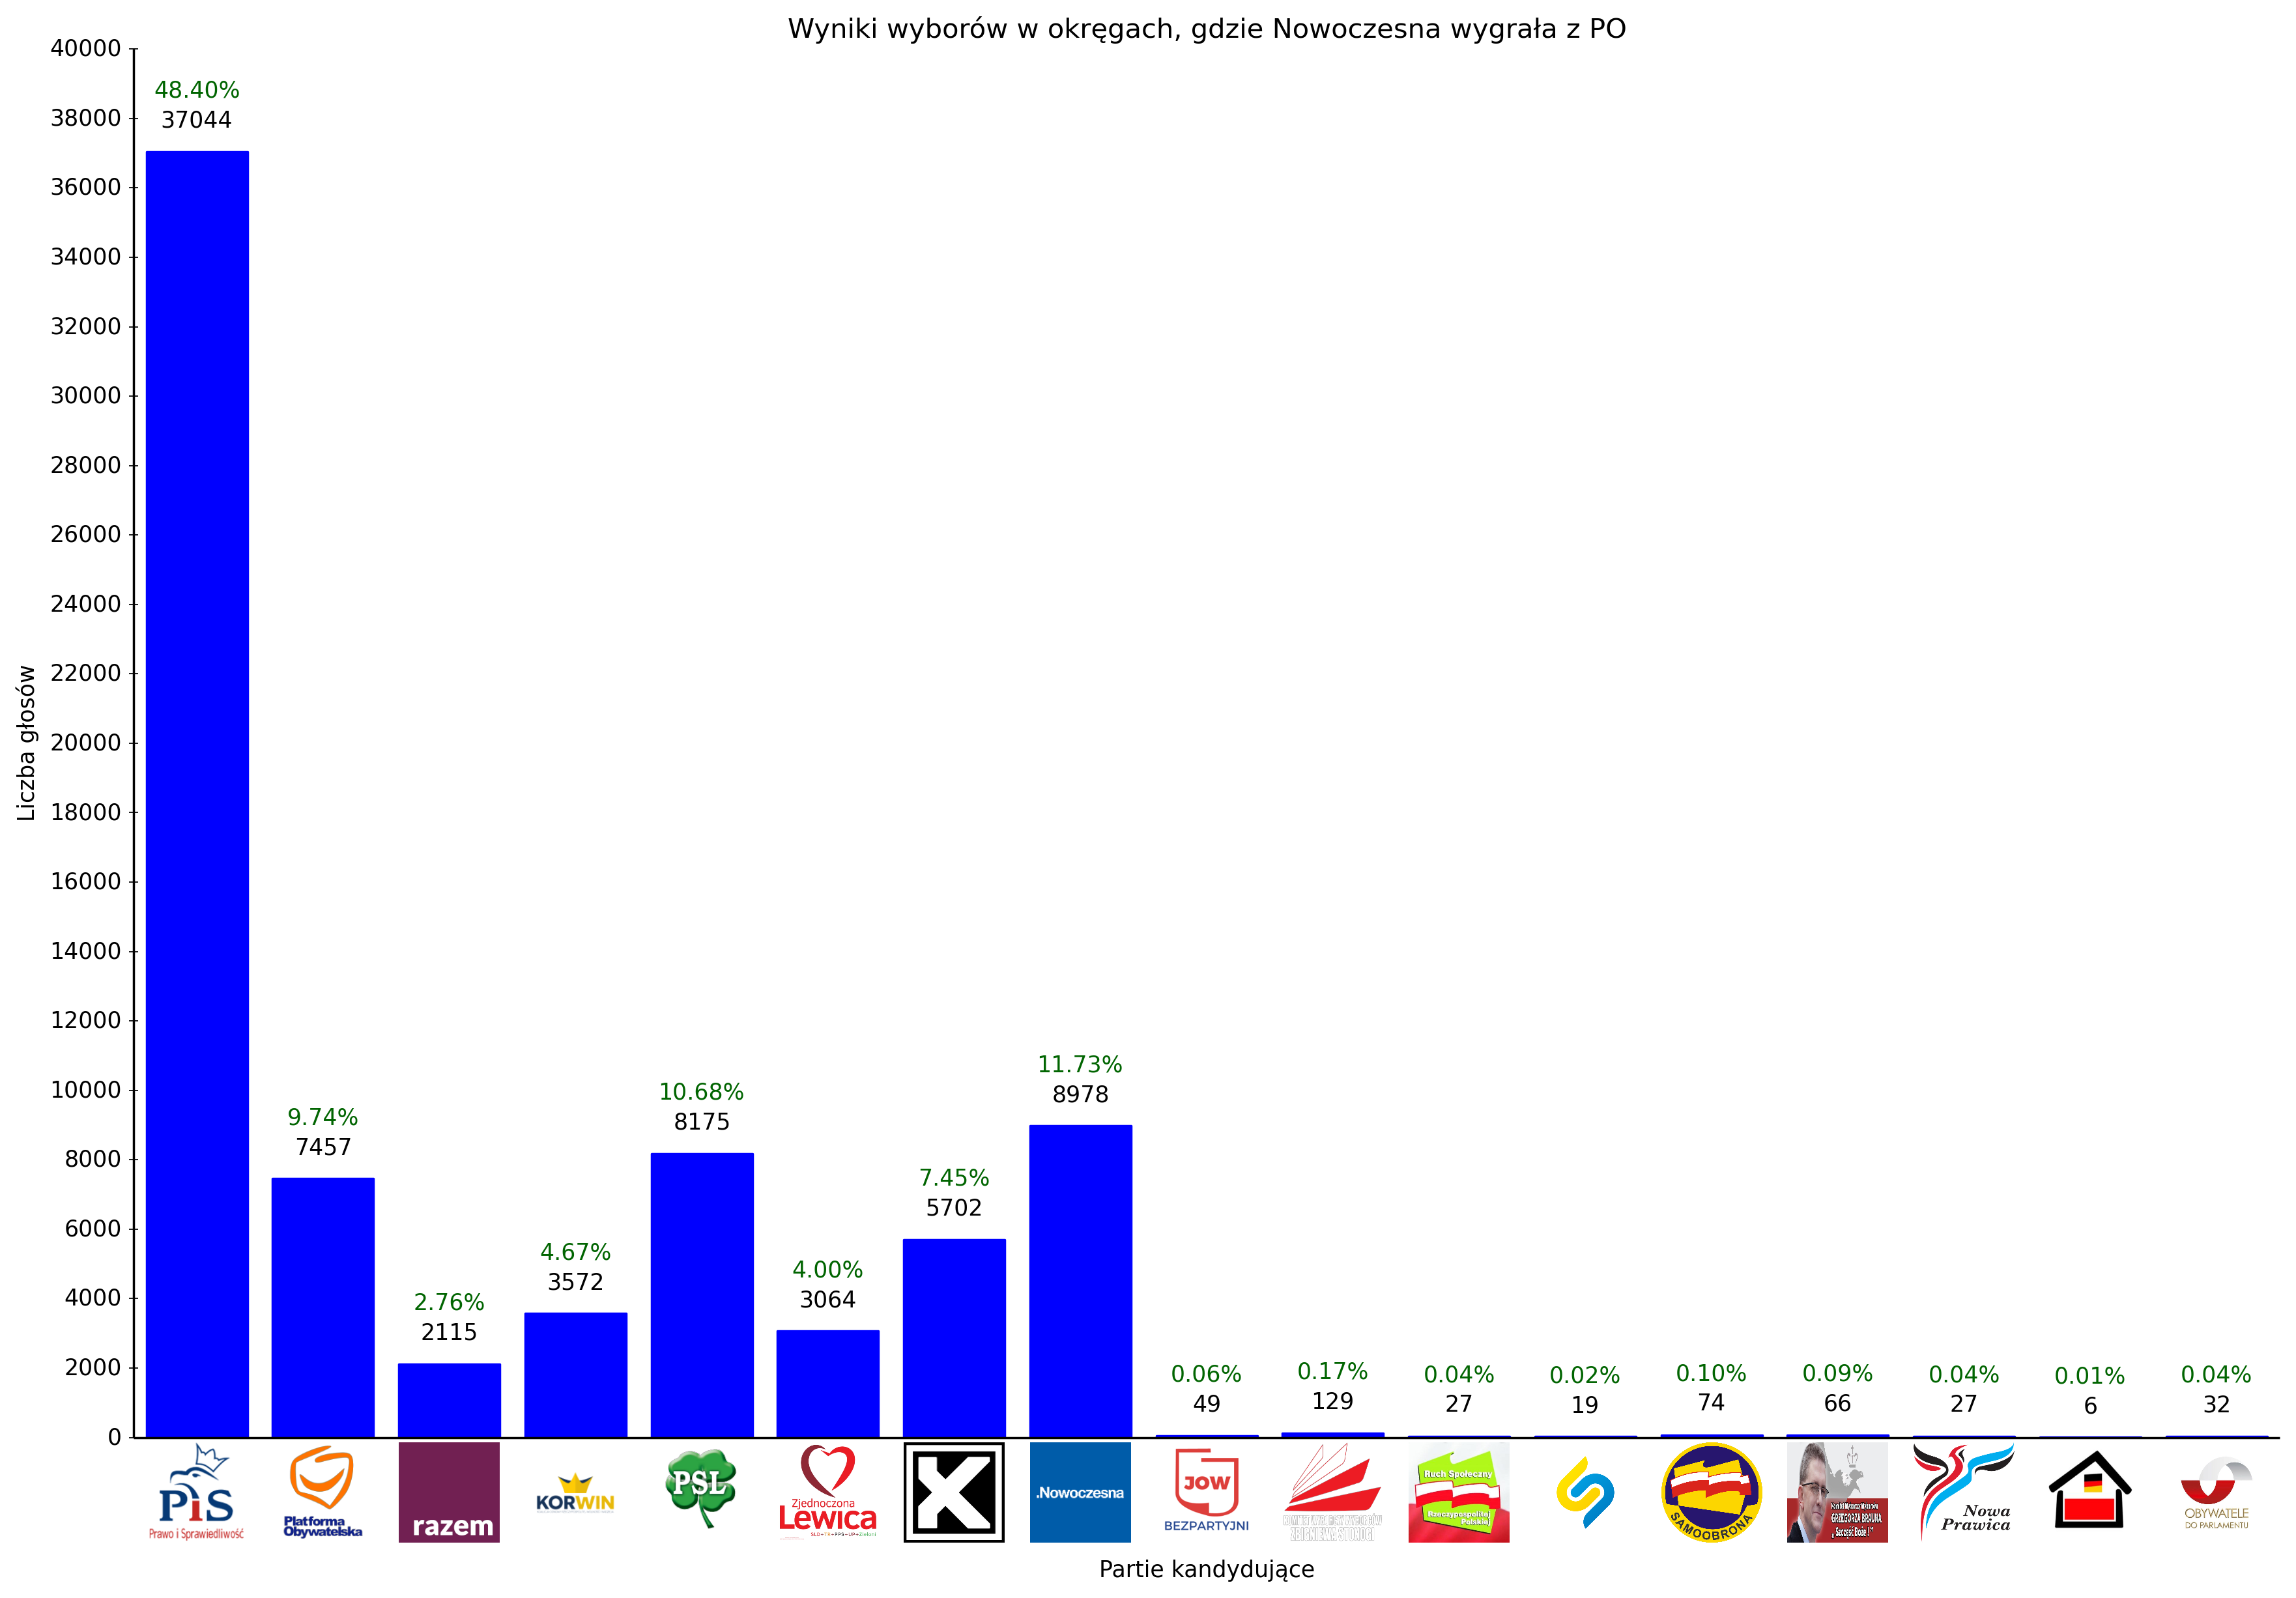

In [36]:
wykres_z_obwodow(obwody=range(len(data)), 
                 savefile="nowoczesnalepszaodpo.png", 
                 color="blue", 
                 title="Wyniki wyborów w okręgach, gdzie Nowoczesna wygrała z PO",
                 warunek=(lambda x: (get_int(data[colnames[29]][x]) <= get_int(data[colnames[35]][x]))))

In [ ]:
wykres_z_obwodow(obwody=range(len(data)), 
                 savefile="psllepszeodkukiza.png", 
                 color="lightgreen", 
                 title="Wyniki wyborów w okręgach, gdzie PSL wygrało z Kukiz'15",
                 warunek=(lambda x: (get_int(data[colnames[34]][x]) <= get_int(data[colnames[32]][x]))))

In [ ]:
wykres_z_obwodow(obwody=moj_adres, 
                 savefile="mojokreg.png", 
                 color="brown",
                 title="Wyniki wyborów w moim okręgu",
                 partie=[1,2,3])

In [ ]:
wykres_z_obwodow(obwody=[i for i in xrange(len(adresy)) if (adresy[i].find("Kraków") != -1)], 
                 savefile="krakow.png", 
                 color="pink", 
                 title="Wyniki wyborów w Krakowie")

In [ ]:
wykres_z_obwodow(obwody=range(len(data)), 
                 savefile="calykraj.png", 
                 color="black", 
                 title="Wyniki wyborów w Polsce")

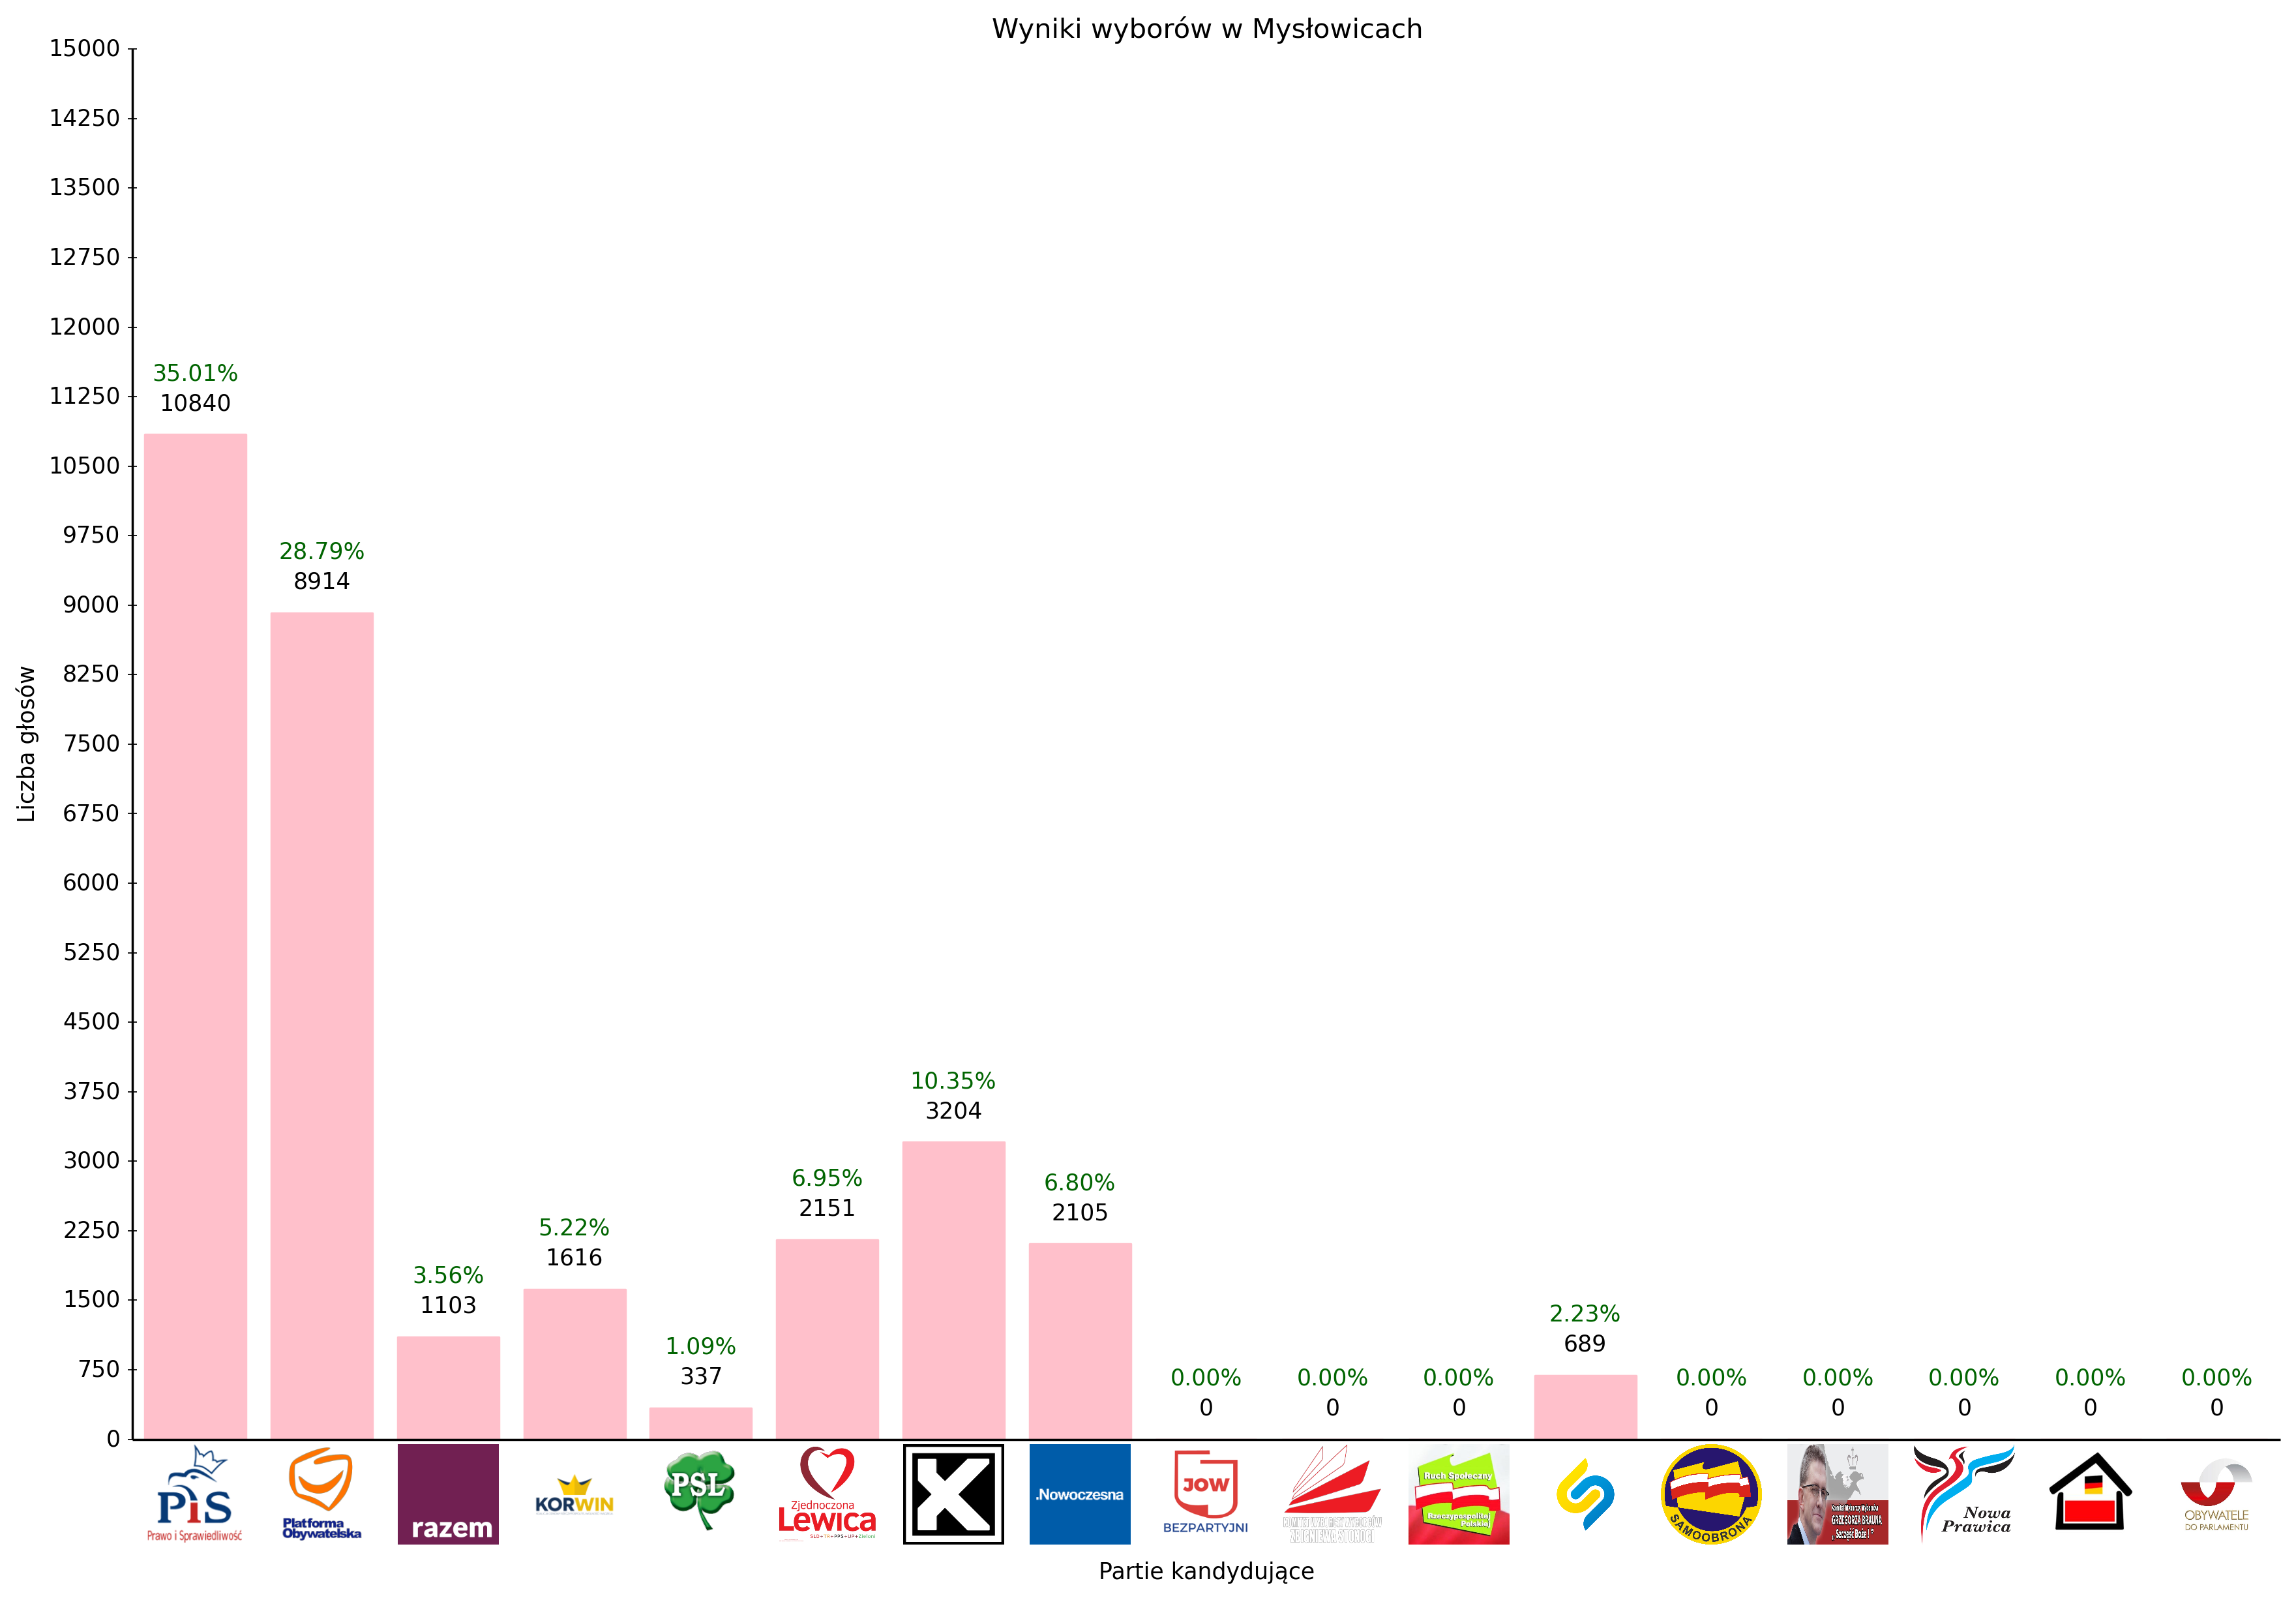

In [11]:
wykres_z_obwodow(obwody=[i for i in xrange(len(adresy)) if (adresy[i].find("Mysłowice") != -1)], 
                 savefile="Mysłowice.png", 
                 color="pink", 
                 title="Wyniki wyborów w Mysłowicach")

In [32]:
def wykres_ciastkowy(partie, obwody):
    glosy = []
    komitety = []
    for i in partie:
        id_partii = i + 27
        komitet = colnames[id_partii]
        ile = sum(get_int(data[colnames[id_partii]][obwod])
                  for obwod in obwody)
        glosy.append(ile)
        komitety.append(komitet)

    komitety2 = [komitety[i] for i in xrange(len(glosy)) if glosy[i] != 0]
    glosy2 = [glosy[i] for i in xrange(len(glosy)) if glosy[i] != 0]

    #glosy2[-1], glosy2[1] = glosy2[1], glosy2[-1]
    #komitety2[-1], komitety2[1] = komitety2[1], komitety2[-1]
    
    kolory = ["red", "blue", "orange", "gray", "green", "brown", "white", "pink", "violet"]

    explode = [0.05] * len(glosy2)
    plt.pie(glosy2,
            labels=[int(x[0:2]) for x in komitety], 
            autopct='%1.2f%%', 
            startangle=0,
            colors=kolory[:len(glosy2)],
            pctdistance=1.35, 
            labeldistance=1.15)
    plt.legend(komitety2, bbox_to_anchor=(1.2, 1.2))
    plt.show()

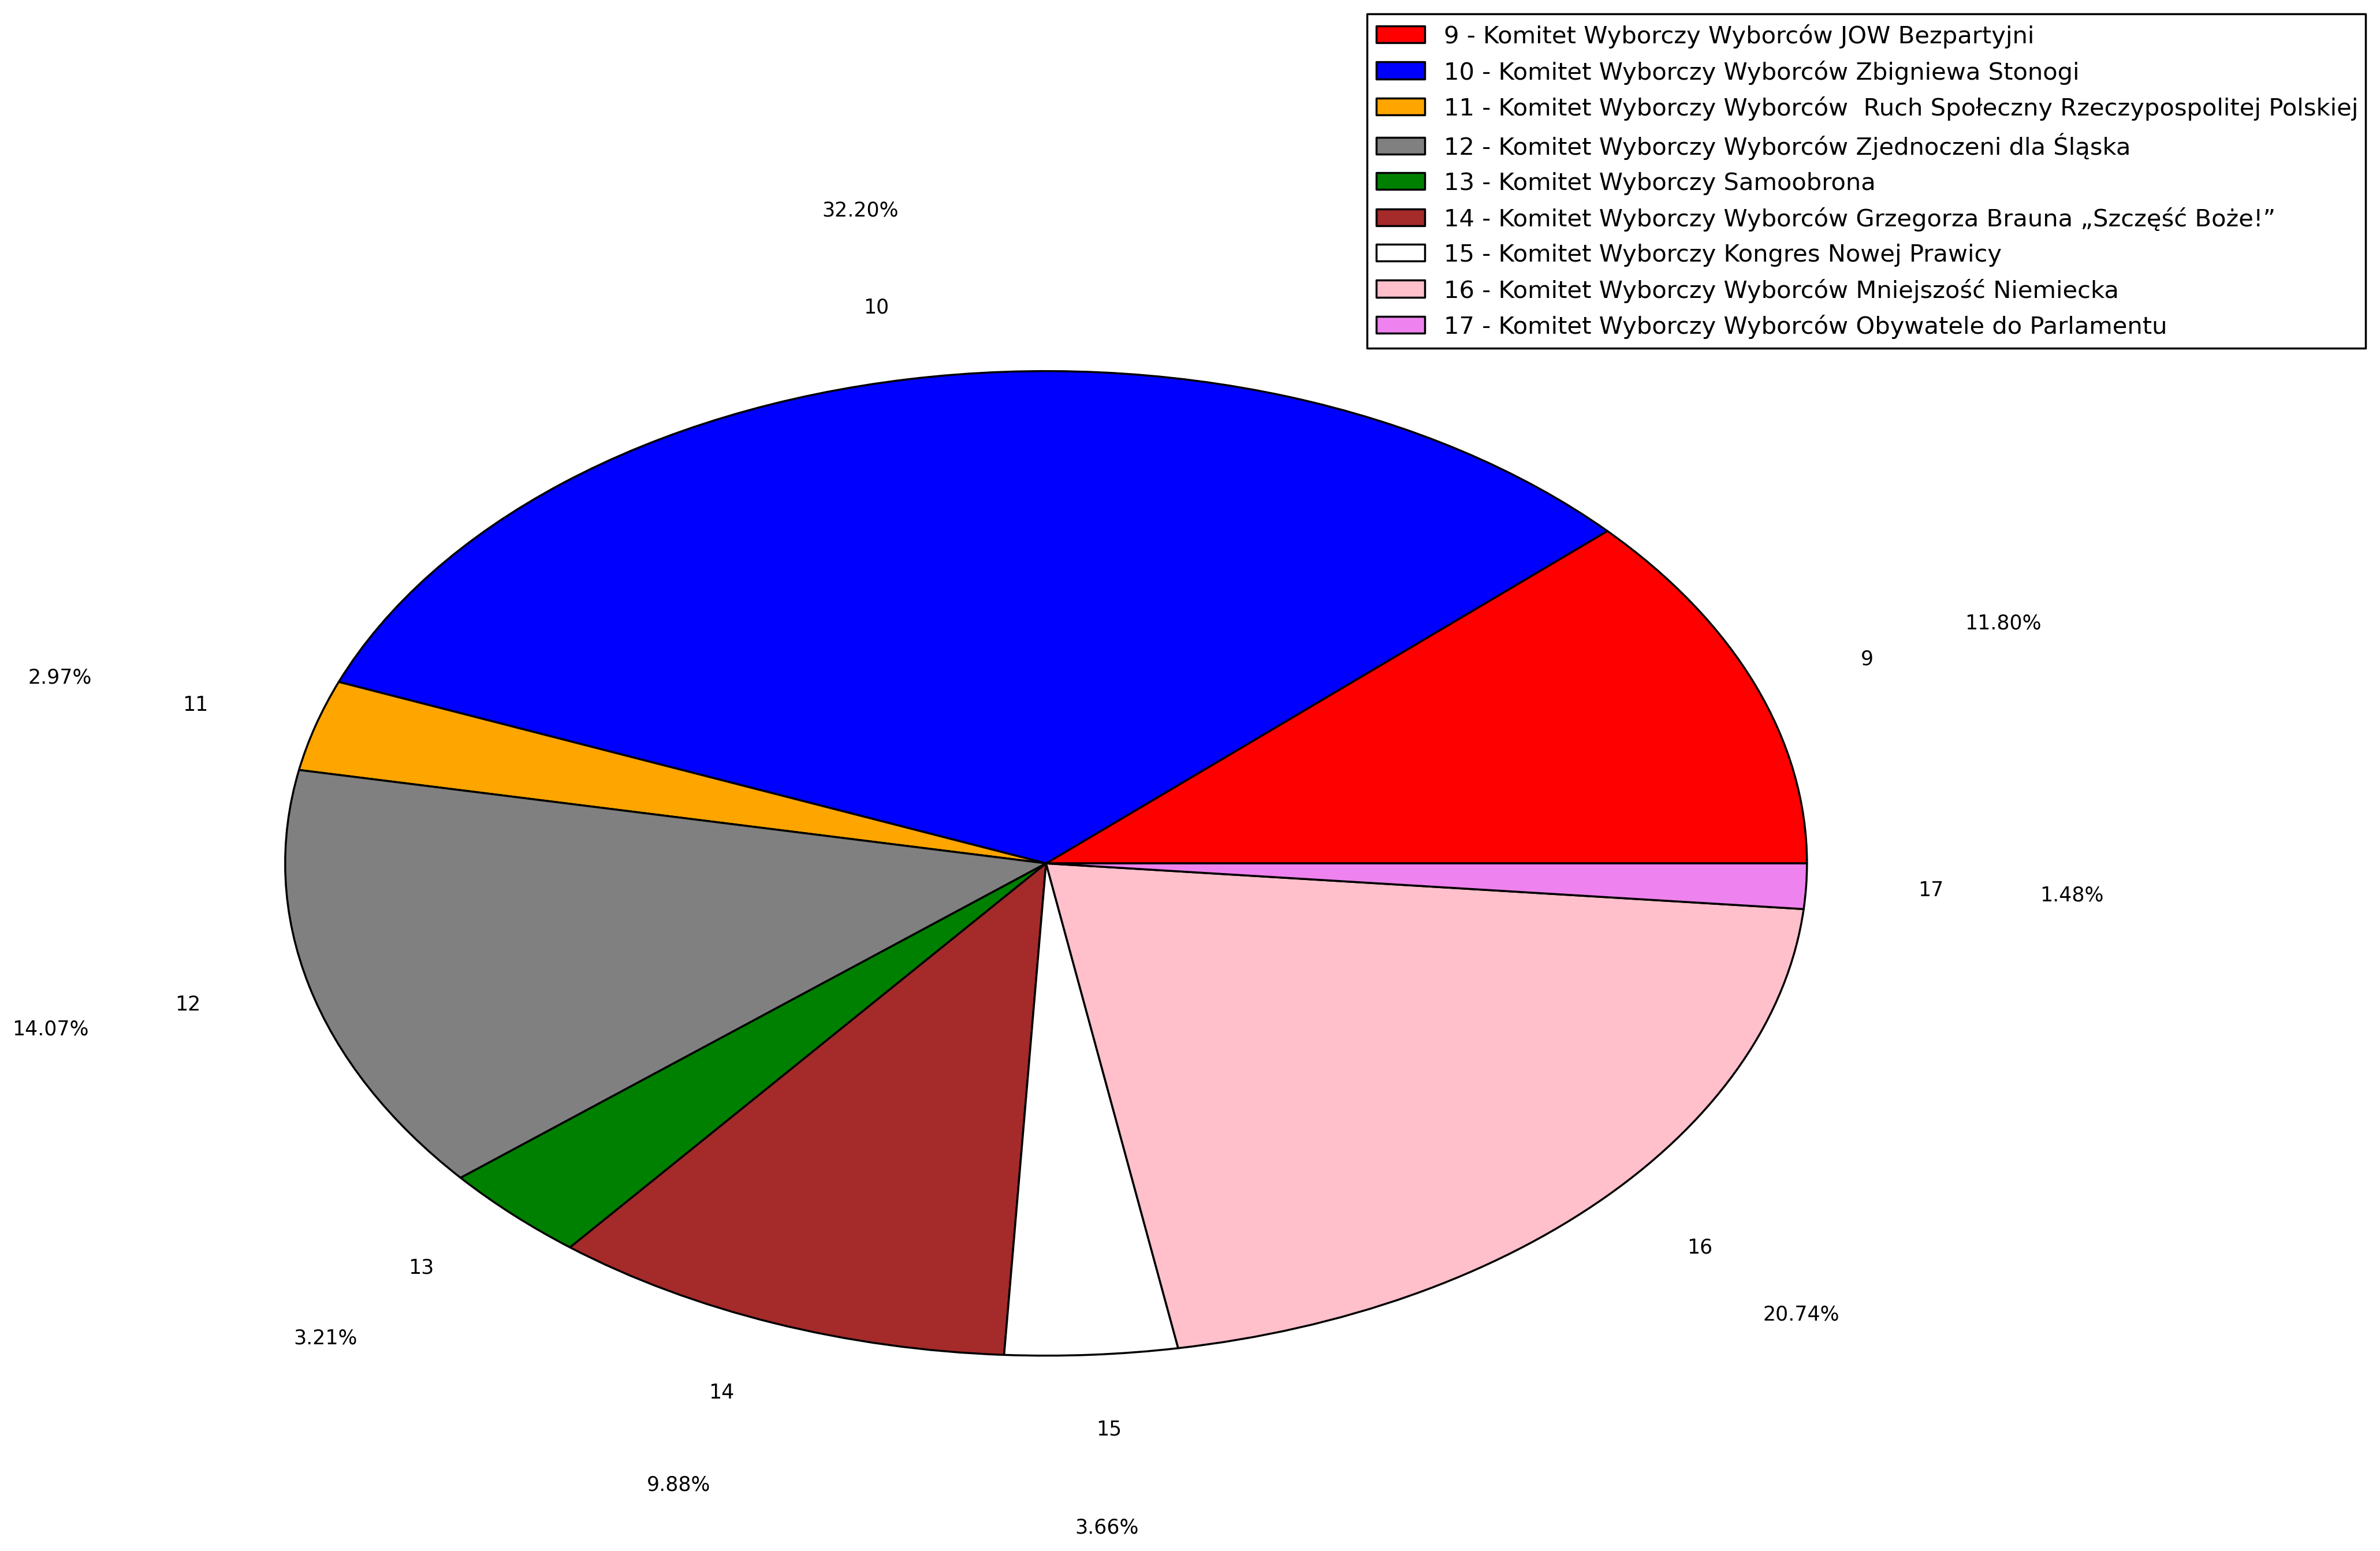

In [33]:
wykres_ciastkowy(range(9, 18), range(len(data)))